<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Bagging Classifiers in Financial Applications
    </h1>
  </div>  
</div>

This notebook explores the theoretical and empirical performance of bagging classifiers using the `RiskLabAI` library.

We will cover the following steps:
1.  Review the **theoretical accuracy** of an ensemble using the binomial distribution.
2.  Fetch **real financial data (S&P 500) from FRED** and engineer features to create a classification problem.
3.  Apply the `BaggingClassifierAccuracy` class to evaluate **three different voting weights** (Uniform, $c_i$, Variance) on the financial data.
4.  Use bootstrapping to analyze the **stability and distribution** of the model's accuracy.

## 0. Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os
import warnings
warnings.filterwarnings("ignore")

# For FRED data
from dotenv import load_dotenv
from fredapi import Fred

# Import from the RiskLabAI library
from RiskLabAI.ensemble import (
    bagging_classifier_accuracy,
    BaggingClassifierAccuracy,
    calculate_bootstrap_accuracy,
    plot_bootstrap_accuracy_distribution
)

# Import plotting utilities (FIXED import path)
import RiskLabAI.utils.publication_plots as pub_plots

# --- User Configuration ---
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run, register for a free FRED API key and create a .env file
# with the line: FRED_API_KEY='YOUR_KEY_HERE'
FRED_API_KEY = os.environ.get('FRED_API_KEY')

if not FRED_API_KEY:
    print("Warning: FRED_API_KEY not found. Please set it in your .env file.")
    # FRED_API_KEY = 'YOUR_FRED_API_KEY' # Or uncomment and paste here


In [2]:
# --- Global Plotting Settings ---
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Theoretical Accuracy

First, we explore the theoretical accuracy of a bagging classifier, as described in De Prado (2018), Chapter 6. Assuming **N** independent classifiers, each with accuracy **p**, the ensemble's accuracy is the probability that the majority are correct. This is modeled using the `bagging_classifier_accuracy` function.

The plot shows that as long as $p > 0.5$, increasing $N$ improves ensemble accuracy.

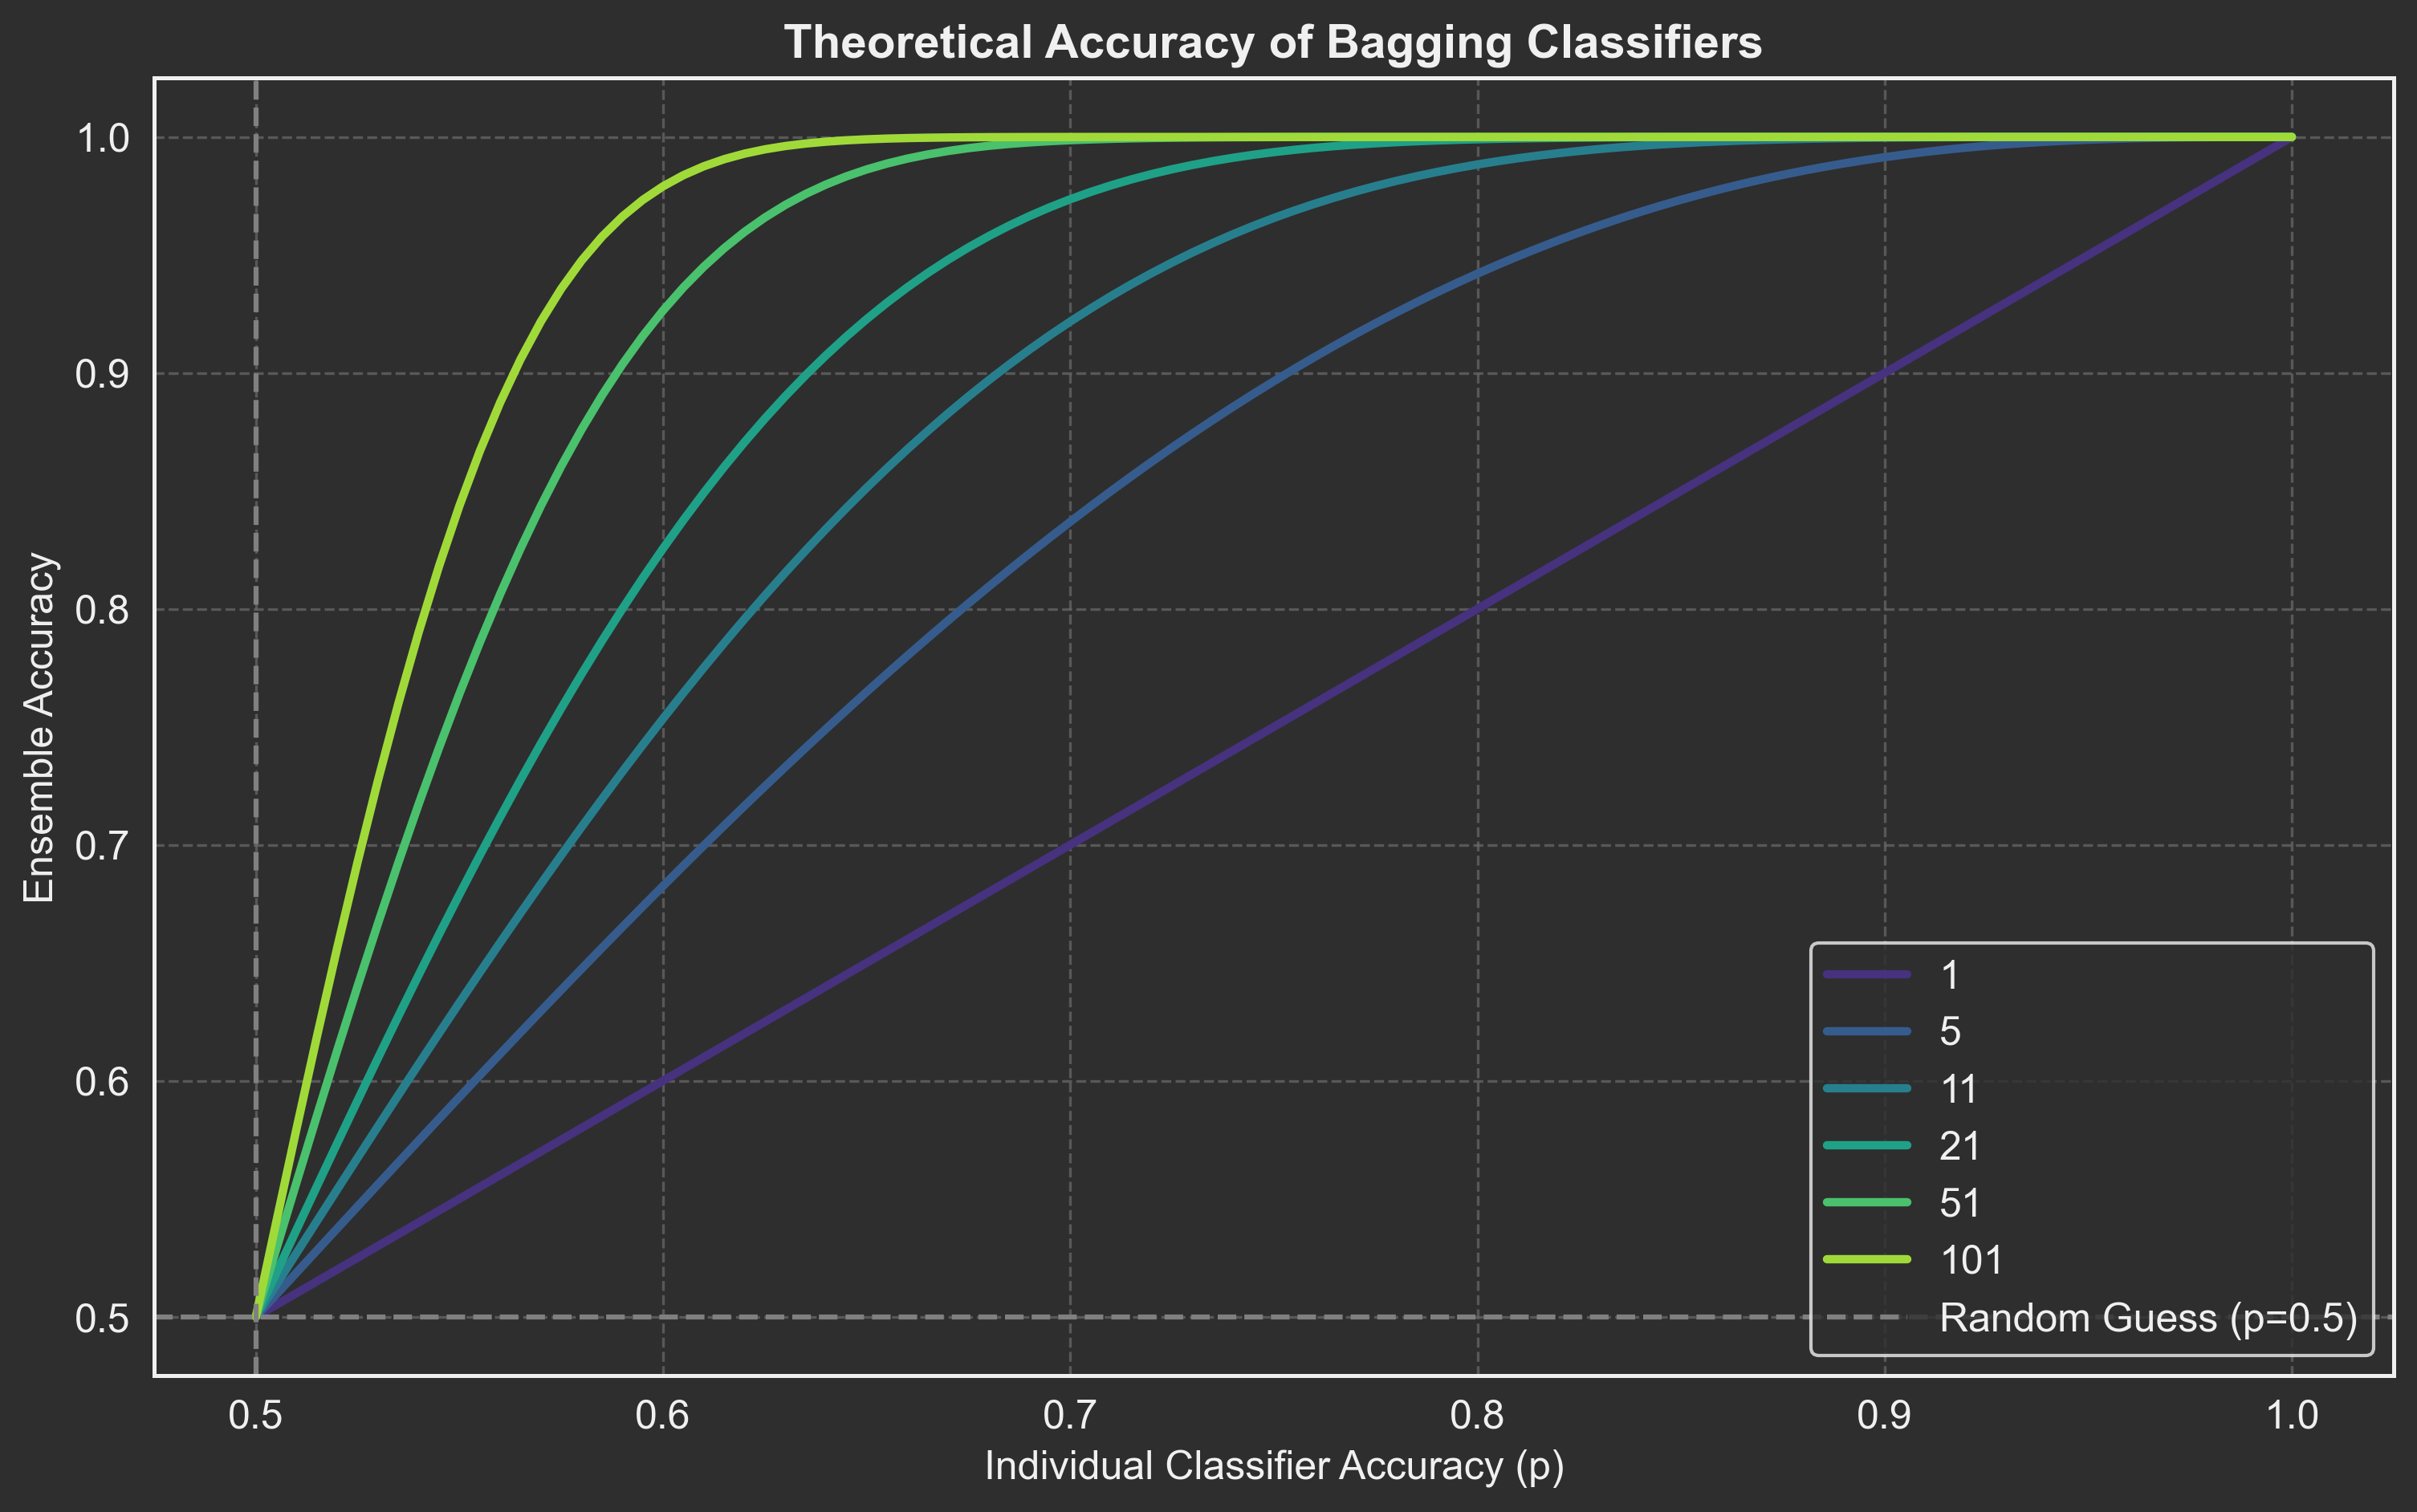

In [3]:
# Define the range for N (number of classifiers) and p (individual accuracy)
N_values = [1, 5, 11, 21, 51, 101]  # Must be odd
p_values = np.linspace(0.5, 1.0, 101)

data = []
for N in N_values:
    for p in p_values:
        if p == 0.5 and N > 1:
            accuracy = 0.5
        else:
            accuracy = bagging_classifier_accuracy(N=N, p=p)
        data.append({'N': N, 'p': p, 'Accuracy': accuracy})

df_theo = pd.DataFrame(data)
df_theo['N'] = df_theo['N'].astype(str)  # Treat N as a category for plotting

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
    data=df_theo,
    x='p',
    y='Accuracy',
    hue='N',
    ax=ax,
    palette='viridis',
    linewidth=2.5
)

pub_plots.apply_plot_style(
    ax=ax,
    title='Theoretical Accuracy of Bagging Classifiers',
    xlabel='Individual Classifier Accuracy (p)',
    ylabel='Ensemble Accuracy',
    legend_title='N (Classifiers)'
)

ax.axhline(0.5, ls='--', color='grey', label='Random Guess (p=0.5)')
ax.axvline(0.5, ls='--', color='grey')
ax.legend(loc='lower right')

pub_plots.finalize_plot(fig, 'theoretical_bagging_accuracy.png')

## 2. Empirical Analysis with Financial Data

Now, we move from theory to practice. We will fetch S&P 500 data from FRED, engineer features, and create a binary label (predicting the *sign* of the next day's return). This creates a realistic classification task to test our empirical bagging classifier.

In [4]:
def get_financial_data(api_key, series_id='SP500', start='2000-01-01'):
    """Fetches and processes S&P 500 data from FRED."""
    if not api_key:
        print("FRED API key not found. Skipping data loading.")
        return pd.DataFrame(), pd.DataFrame()
    
    fred = Fred(api_key=api_key)
    
    # Fetch S&P 500 data
    data = fred.get_series(series_id, start_date=start)
    data = data.to_frame(name='Close')
    data.dropna(inplace=True)

    # 1. Calculate log returns
    data['Returns'] = np.log(data['Close']).diff()

    # 2. Engineer features
    data['Lag_1'] = data['Returns'].shift(1)
    data['Lag_2'] = data['Returns'].shift(2)
    data['Lag_5'] = data['Returns'].shift(5)
    data['Volatility'] = data['Returns'].rolling(window=21).std()
    data['Momentum'] = data['Returns'].rolling(window=5).mean()

    # 3. Create binary label (sign of next day's return)
    data['Label'] = np.sign(data['Returns'].shift(-1))

    # 4. Clean data
    # Drop NaNs created by features/labels
    data.dropna(inplace=True)
    # Drop days with zero return (no signal)
    data = data[data['Label'] != 0]
    # Map labels from {-1, 1} to {0, 1}
    data['Label'] = (data['Label'] > 0).astype(int)

    # 5. Define X and y
    features = ['Lag_1', 'Lag_2', 'Lag_5', 'Volatility', 'Momentum']
    X = data[features]
    y = data['Label']
    
    return X, y

# Get data
X, y = get_financial_data(FRED_API_KEY)

if not X.empty:
    print(f"Data loaded. X shape: {X.shape}, y shape: {y.shape}")
    print(X.head())

Data loaded. X shape: (2492, 5), y shape: (2492,)
               Lag_1     Lag_2     Lag_5  Volatility  Momentum
2015-12-16  0.010563  0.004744 -0.007769    0.010090  0.002470
2015-12-17  0.014411  0.010563  0.002249    0.010648 -0.001010
2015-12-18 -0.015155  0.014411 -0.019614    0.010641 -0.000679
2015-12-21 -0.017958 -0.015155  0.004744    0.010844 -0.000078
2015-12-22  0.007748 -0.017958  0.010563    0.011016 -0.000435


In [5]:
# Split data into train and test sets (80/20 split)
if not X.empty:
    split = int(len(X) * 0.8)
    
    X_train = X.iloc[:split]
    y_train = y.iloc[:split]
    
    X_test = X.iloc[split:]
    y_test = y.iloc[split:]

    print(f"Train set: {len(X_train)} samples")
    print(f"Test set:  {len(X_test)} samples")

Train set: 1993 samples
Test set:  499 samples


### 2.1 Evaluate All Weighting Schemes

We now use the `BaggingClassifierAccuracy` class to evaluate three weighting schemes described by De Prado:

1.  **Uniform:** Standard bagging (all trees vote equally).
2.  **$c_i$:** Votes are weighted by the tree's accuracy ($c_i$) on the *training set*.
3.  **Variance:** Votes are weighted by $1 - c_i^2$, giving more weight to trees with accuracy further from 0.5.

In [6]:
if not X.empty:
    # Initialize the evaluator class
    bagging_evaluator = BaggingClassifierAccuracy(
        n_estimators=1000,   # Number of trees
        max_samples=100,     # Samples per tree (bootstrapping)
        max_features=1.0,  # Note: base_estimator inside class restricts to 1 feature
        random_state=42
    )

    # Evaluate all schemes
    accuracies = bagging_evaluator.evaluate_all_schemes(
        X_test=X_test,
        y_test=y_test,
        X_train=X_train,
        y_train=y_train
    )

    print("Test Set Accuracies by Weighting Scheme:")
    for scheme, acc in accuracies.items():
        print(f"- {scheme.capitalize()}: {acc:.4f}")
else:
    print("Skipping empirical analysis as data was not loaded.")

c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.w

Test Set Accuracies by Weighting Scheme:
- Uniform: 0.5631
- C_i: 0.5611
- Variance: 0.5591


c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Hamid\.conda\envs\risklab311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.w

### 2.2 Analyze $c_i$ Score Distribution

Let's look at the distribution of the $c_i$ scores (the accuracy of each individual tree on the full training set). This is what's used to determine the `c_i` and `variance` weights.

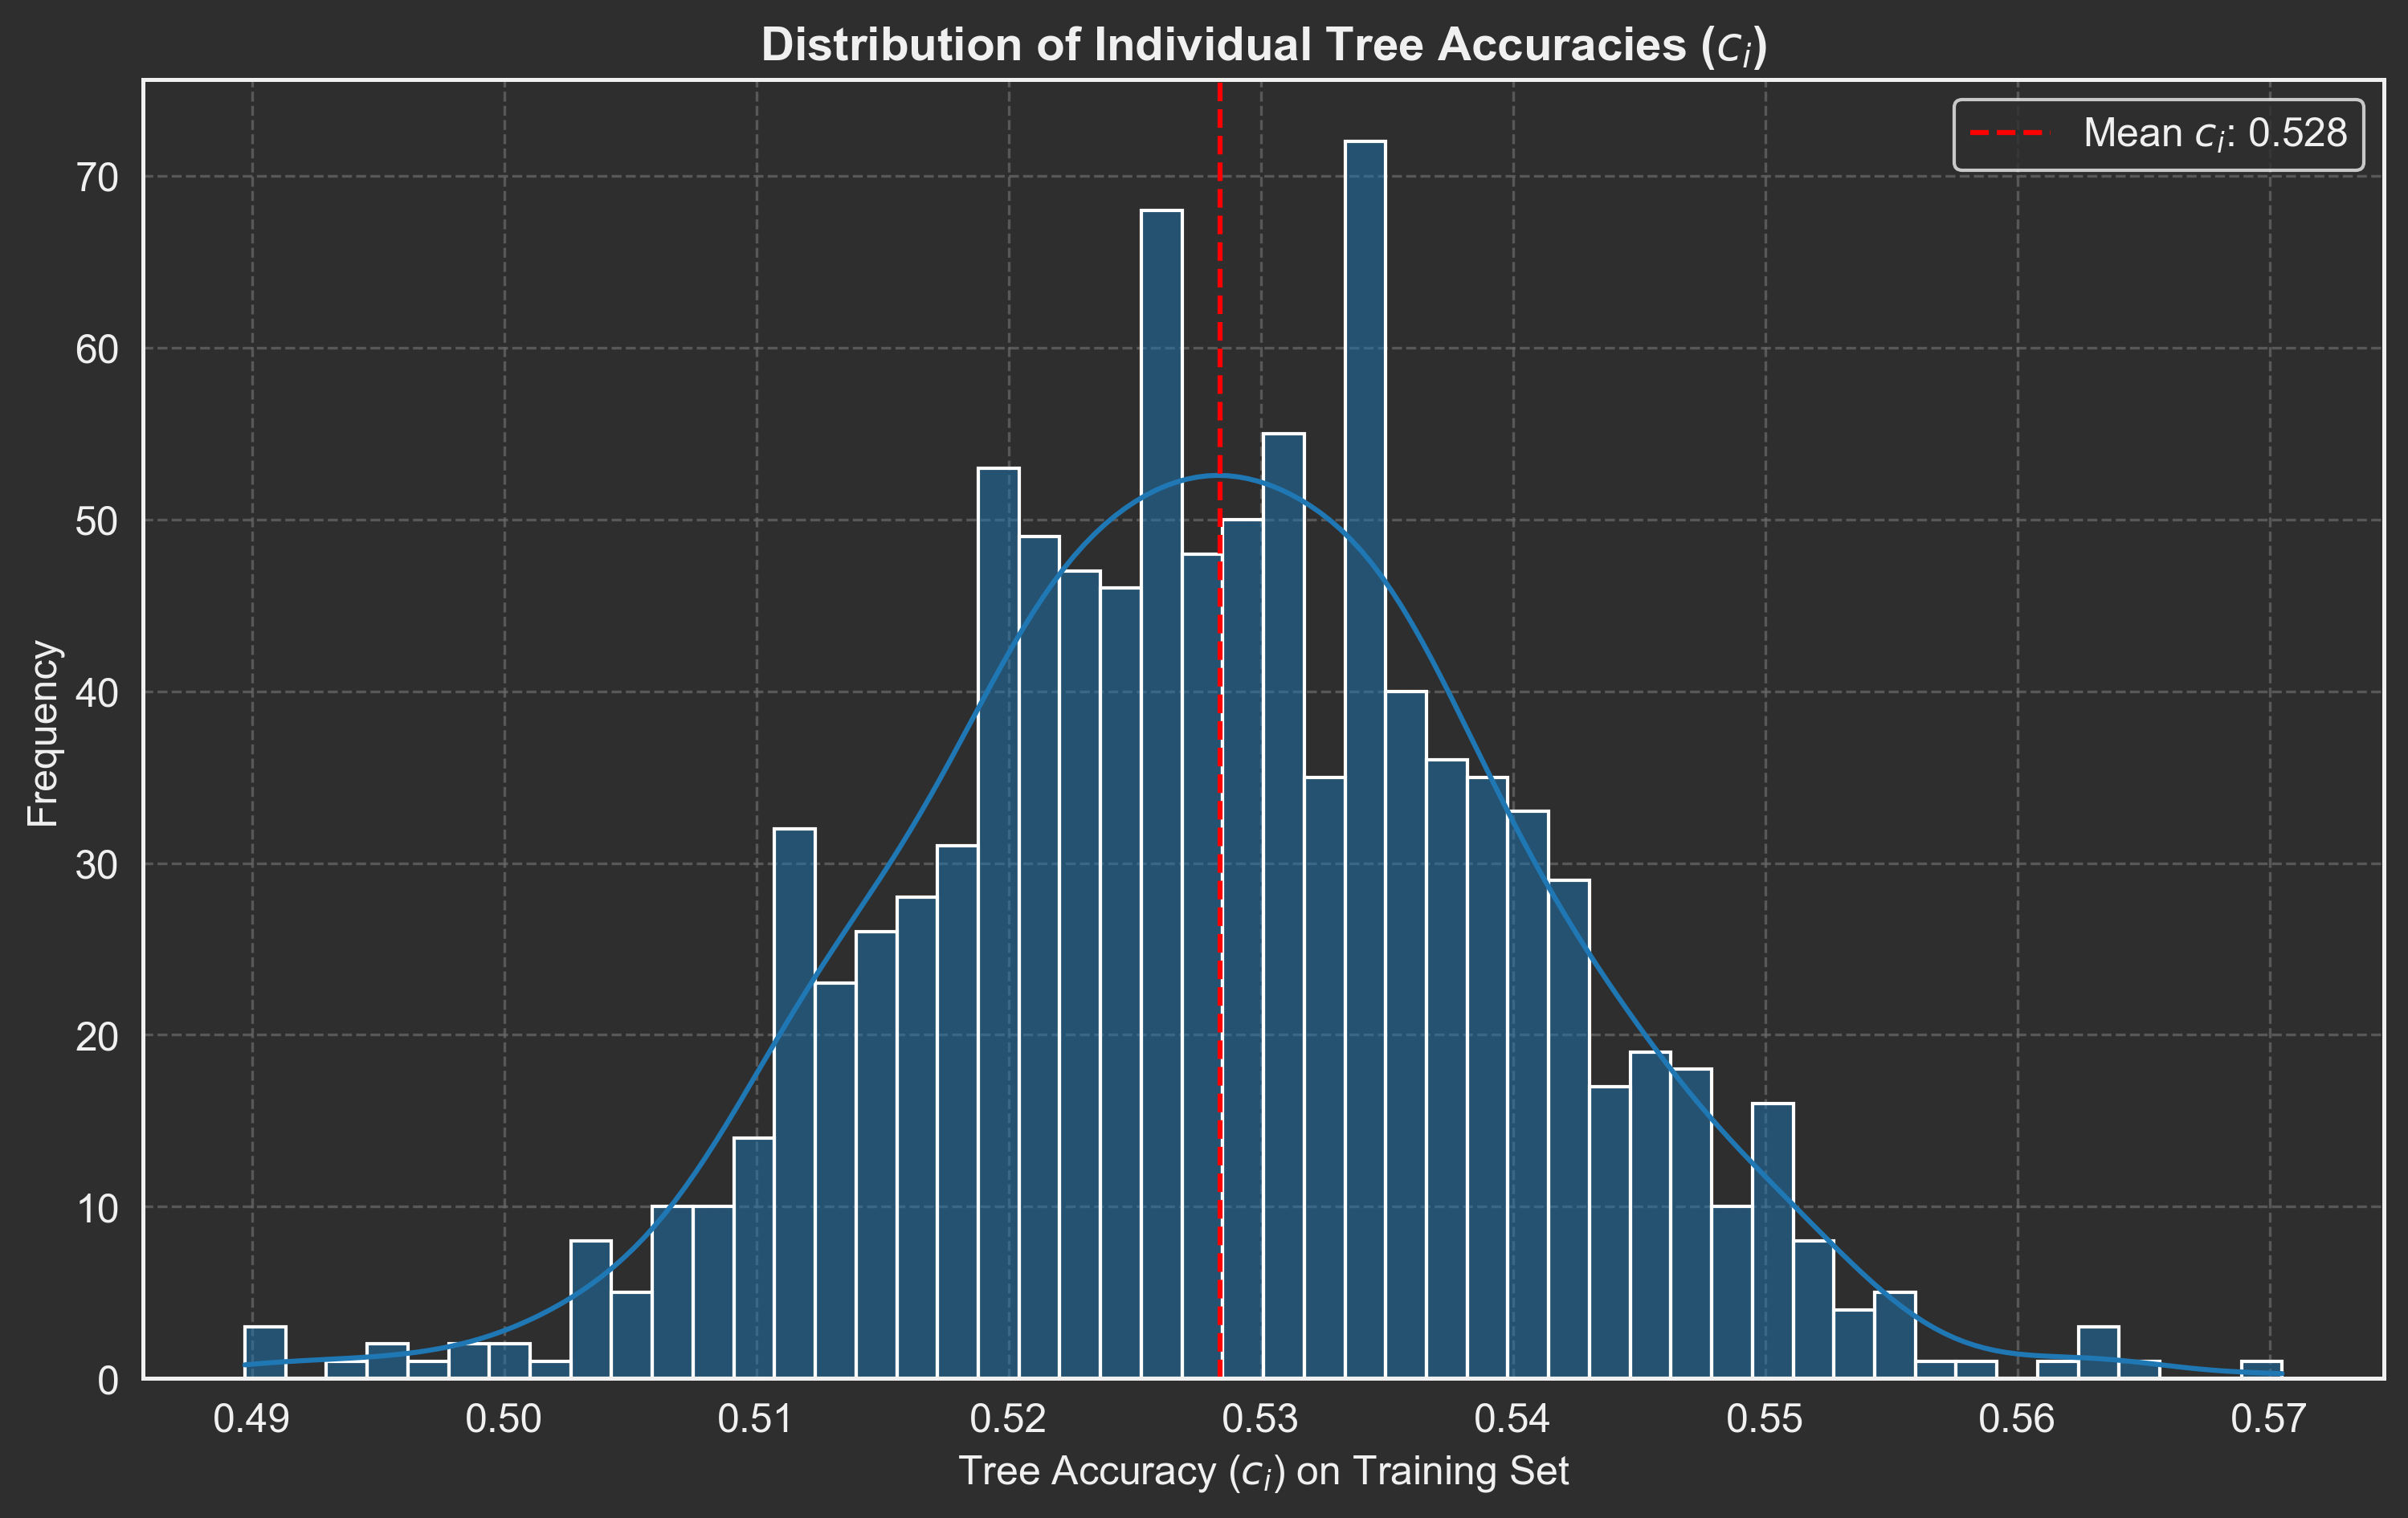

In [7]:
if not X.empty:
    c_i_scores = bagging_evaluator.c_i_scores_

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.histplot(c_i_scores, kde=True, ax=ax, bins=50)

    mean_c_i = np.mean(c_i_scores)
    ax.axvline(mean_c_i, ls='--', color='red', label=f'Mean $c_i$: {mean_c_i:.3f}')

    pub_plots.apply_plot_style(
        ax=ax,
        title='Distribution of Individual Tree Accuracies ($c_i$)',
        xlabel='Tree Accuracy ($c_i$) on Training Set',
        ylabel='Frequency'
    )
    ax.legend()

    pub_plots.finalize_plot(fig, 'ci_score_distribution.png')
else:
    print("Skipping c_i plot as data was not loaded.")

## 3. Bootstrapping the Accuracy Estimate

A single accuracy score doesn't tell us how stable our model is. To get a confidence interval around our accuracy estimate (specifically, the standard `uniform` scheme), we can bootstrap the test set using the `calculate_bootstrap_accuracy` helper function.

In [ ]:
if not X.empty:
    # Get the fitted scikit-learn BaggingClassifier instance (uniform weights)
    fitted_clf = bagging_evaluator.clf

    # Calculate bootstrap accuracies
    a_n_values, a_n_mean, a_n_std = calculate_bootstrap_accuracy(
        clf=fitted_clf,
        X=X_test,
        y=y_test,
        n_bootstraps=1000
    )

    print(f"Bootstrapped Accuracy (Uniform Weights):")
    print(f"Mean (a_n):    {a_n_mean:.4f}")
    print(f"Std (std_a_n): {a_n_std:.4f}")
else:
    print("Skipping bootstrap analysis as data was not loaded.")

### 3.1 Plot the Accuracy Distribution

This plot shows the empirical distribution of the accuracy scores from the 1,000 bootstraps. We overlay a Normal distribution to confirm that the scores are approximately normally distributed.

In [ ]:
if not X.empty:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Use the dedicated plotting function from the module
    plot_bootstrap_accuracy_distribution(
        a_n_values=a_n_values,
        a_n_mean=a_n_mean,
        a_n_std=a_n_std,
        ax=ax
    )

    pub_plots.apply_plot_style(
        ax=ax,
        title='Distribution of Bootstrapped Accuracies',
        xlabel='Accuracy Score',
        ylabel='Density'
    )

    pub_plots.finalize_plot(fig, 'bootstrapped_accuracy_distribution.png')
else:
    print("Skipping bootstrap plot as data was not loaded.")